## Пункт 2. Использование вариантов SGD (torch.optim) из PyTorch

In [237]:
import torch
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA
plt.rcParams["figure.figsize"] = (10, 5)

### custom SGD

In [238]:
DEFAULT_LR = 0.01
njev = 0
nfev = 0

constant_lr = (lambda current_lr, epoch: DEFAULT_LR)

def step_decay(lr, epoch, epochs_drop = 20, drop = 0.5):
   return lr * pow(drop, floor((1 + epoch) / epochs_drop))

In [239]:
# linear function, computes k-th coordinate by k-1 first
#   coefficients - k-1-dim array
#   x - k-1-dim array
def f(coefficients, x, delta = 0.):
    return np.sum(coefficients * x) + delta

class point_set:
    def __init__(self, n, dim, x, y, coefficients, delta, coords_bound = 0.):
        self.n = n
        self.dim = dim
        self.x = np.asarray(x, dtype=np.float64)
        self.y = np.asarray(y, dtype=np.float64)
        self.coefficients = coefficients
        self.delta = delta
        self.coords_bound = coords_bound

# create point_set:
# n - amount of points
# dim - space's dim
# coords_bound - upper bound on absolute first k-1 coordinates value
# coefficients_bound - upper bound on absolute coefficients value
def create_point_set(n, dim, coords_bound, coefficients_bound, coefficients = []):
    x = coords_bound * np.random.random_sample((n, dim - 1))
    if coefficients == []:
        coefficients = coefficients_bound * np.random.random_sample((dim - 1)) - coefficients_bound
    else:
        coefficients = np.asarray(coords_bound)

    y = np.asarray([])
    delta = np.asarray([0] * n)
    for i in range(0, n):
        delta[i] = coefficients_bound * (2 * np.random.random_sample() - 1)
        y = np.append(y, f(coefficients, x[i], delta[i]))
    return point_set(n, dim, x, y, coefficients, delta, coords_bound)


EPOCH_MAX = 500
input_2d = create_point_set(200, 2, 20., 10.)
input_large = create_point_set(200, 10, 20., 10.)

In [240]:
def loss_function(points, coeffs, i):
    return 1 / (points.n) * np.square(coeffs[points.dim - 1] + np.sum(coeffs[0 : points.dim - 1] * points.x[i]) - points.y[i]) 

def apply_all_loss_functions(points, coeffs):
    result = 0.
    for i in range(0, points.dim):
        result += loss_function(points, coeffs, i)
    return result

In [241]:
def gradient_compute(points, coeffs, id, h=1e-5):
    dim = points.dim
    grad = np.asarray([0.] * dim)
    step = np.asarray([0.] * dim)
    for i in range(0, dim):
        step[i] = h
        grad[i] = (loss_function(points, coeffs + step, id) - loss_function(points, coeffs - step, id)) / (2 * h)
        step[i] = 0.
    return grad

def loss_function_grad(points, ids, coeffs):
    result = np.asarray([0.] * points.dim)
    for i in ids:
        result += gradient_compute(points, coeffs, i)
    return result

In [242]:
def sgd(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, _param_1, _param_2):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index : to], coeffs)
        coeffs_step = coeffs - current_lr * np.asarray(grad)
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [243]:
def sgd_with_momentum(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, param_2):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    batch_index = 0
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + (1 - betta) * gradinet_supplier(points, order[batch_index:to], coeffs)
        coeffs_step = coeffs - current_lr * grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [244]:
def nesterov_loss_function_grad(points, ids, coeffs, betta, grad):
    result = np.asarray([0.] * points.dim)
    for i in ids:
        result += gradient_compute(points, coeffs - betta * grad, i)
    return result

def sgd_with_nesterov_momentum(points, batch_size, _gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    batch_index = 0

    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + current_lr * nesterov_loss_function_grad(points, order[batch_index:to], coeffs, betta, grad)
        coeffs_step = coeffs - grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        coeffs = coeffs_step
        loss_history.append(apply_all_loss_functions(points, coeffs))

        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [245]:
def adagrad(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        v = prev_v + np.power(grad, 2)
        coeffs_step = coeffs - np.divide(grad, np.power(v, 0.5)) * current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        prev_v = v
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [246]:
def rms_prop(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        v = prev_v * betta + (1 - betta) * np.power(grad, 2)
        coeffs_step = coeffs - np.divide(grad, np.power(v, 0.5)) * current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        prev_v = v
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]

In [247]:
def adam(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    total_epoches = 0
    loss_history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    prev_grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    epsilon = np.asarray([0.01] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        
        grad_current = betta * prev_grad + (1-betta) * grad
        v = prev_v*gamma + (1-gamma)*np.power(grad, 2)

        coeffs_step = coeffs - np.divide(grad_current, (np.power(v, 0.5) + epsilon))*current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        total_epoches += 1
        loss_history.append(apply_all_loss_functions(points, coeffs))
        coeffs = coeffs_step
        prev_v = v
        prev_grad = grad_current
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, total_epoches, loss_history]


### torch.optim SGD

In [248]:
def Linear_to_array(model):
    return np.append(model.weight.detach().numpy()[0], model.bias.detach().numpy()[0])

In [249]:
def linear_regression(coeffs, points):
    y = np.asarray([0.] * points.n)
    for i in range(0, points.n):
        y[i] = coeffs[points.dim - 1] + np.sum(coeffs[0 : points.dim - 1].detach().numpy() * points.x[i])
    return torch.tensor(y, requires_grad=True)

# points - point_set instance
def torch_sgd(points, model, optimizer, scheduler, eps):
    xs = torch.tensor(points.x, requires_grad=True).float()
    ys = torch.tensor(np.asarray([points.y]).T).float()

    loss_history = list()
    error_history = list()
    total_epoches = 0
    
    previous_coeffs = np.zeros(points.dim)

    for epoch in range(0, EPOCH_MAX):
        coeffs = model(xs)
        loss = torch.nn.functional.mse_loss(coeffs, ys)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        current_coeffs = Linear_to_array(model)
        if LA.norm(current_coeffs - previous_coeffs) <= eps:
            break
        
        previous_coeffs = current_coeffs

        total_epoches += 1
        loss_history.append(float(loss) / points.n)
        
    return [Linear_to_array(model), total_epoches, loss_history]
        

### tests 

In [250]:
def draw_2d_result(points, result):
    plt.plot(points.x, points.y, 'o', markersize=1)
    grid = np.linspace(np.min(points.x), np.max(points.x), 1000)
    plt.title('Point set and evaluated function')
    plt.plot(grid, result[0][0] * grid + result[0][1])
    plt.show()

def print_result(points, result, tittle=''):
    print(tittle, "sgd result:")
    print("coeffs:", result[0])
    print("epoches:", result[1])
    print("loss:", result[2][-1])
    
    if points.dim == 2:
        draw_2d_result(points, result)

    print('\n')

def draw_loss(custom_result, result):
    plt.plot(custom_result, label='custom loss')
    plt.plot(result, label='torch loss')
    plt.grid()
    plt.legend()
    plt.show()


In [251]:
def compare_sgd(points, optimizer_getter, custom_gd, current_lr, eps = 1e-6, param_1 = 0, param_2 = 0):

    model = torch.nn.Linear(points.dim - 1, 1)
    starting_coeffs = Linear_to_array(model)

    optimizer = optimizer_getter(model)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 2, 0.5)
    
    custom_result = custom_gd(points, points.n * 2 // 5, loss_function_grad, starting_coeffs, step_decay, current_lr, eps, EPOCH_MAX, param_1, param_2)    
    result = torch_sgd(points, model, optimizer, scheduler, eps)

    print_result(points, custom_result, 'custom')
    print_result(points, result, 'torch')
    draw_loss(custom_result[2], result[2])

#### SGD

custom sgd result:
coeffs: [-6.52719762 -0.12244006]
epoches: 34
loss: 0.43789534333124713


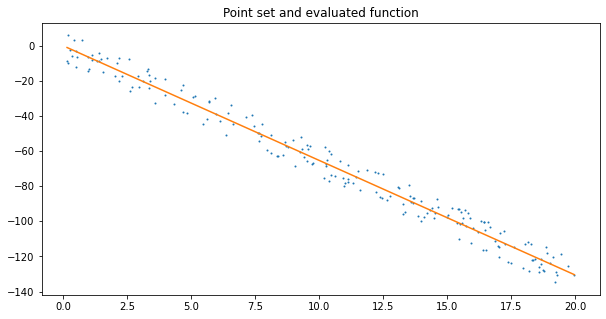



torch sgd result:
coeffs: [-6.4550567  -0.11045749]
epoches: 36
loss: 0.161919002532959


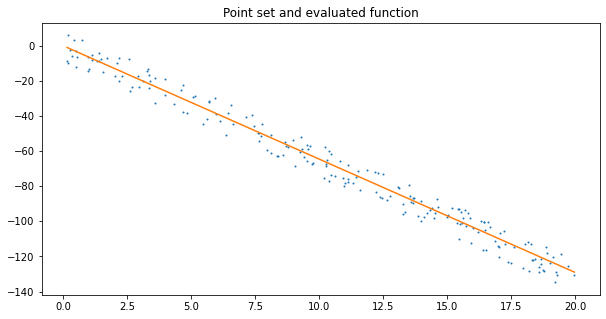

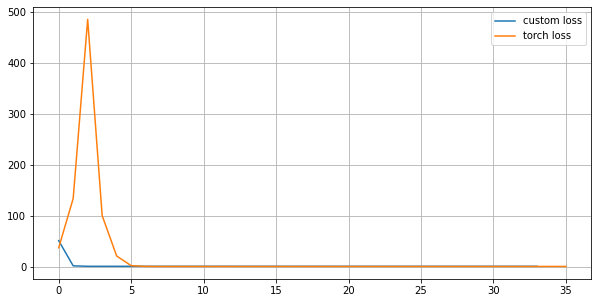

===large input===

custom sgd result:
coeffs: [-5.13540492 -6.40325723 -6.30645227 -3.91060517 -6.65289114 -6.78994316
 -6.6393734  -5.54935697 -5.89954968 -0.6107957 ]
epoches: 35
loss: 34.470082347092166


torch sgd result:
coeffs: [-5.3761344 -6.34654   -6.3947845 -4.5383897 -6.4374948 -6.251038
 -6.525089  -5.4693685 -5.8573823 -0.6023221]
epoches: 38
loss: 6.046605224609375




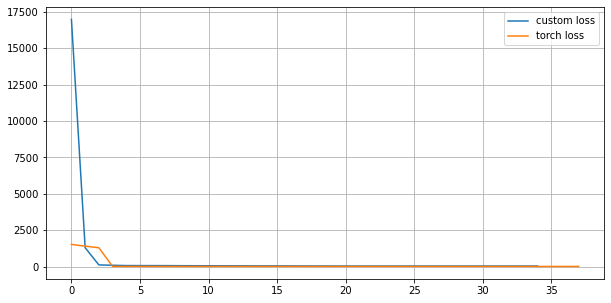

In [252]:
compare_sgd(input_2d, lambda model: torch.optim.SGD(model.parameters(), lr=DEFAULT_LR), sgd, DEFAULT_LR)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.SGD(model.parameters(), lr=0.001), sgd, 0.001)

#### SGD with momentum

custom sgd result:
coeffs: [-6.38040566 -1.16988562]
epoches: 35
loss: 0.35818739974332614


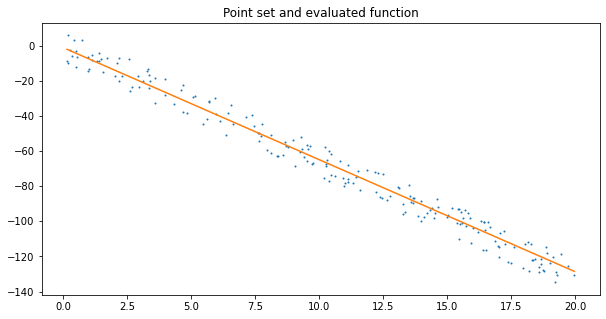



torch sgd result:
coeffs: [-6.011979  -1.1321182]
epoches: 44
loss: 0.3005842781066895


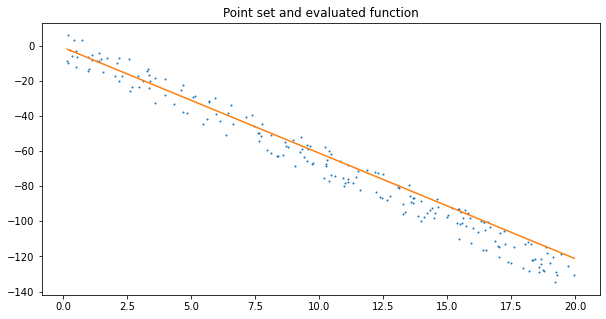

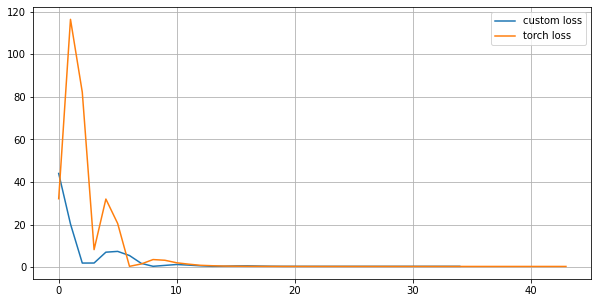

===large input===

custom sgd result:
coeffs: [-3.21991912e+00 -7.59269105e+00 -5.37139708e+00  4.06368150e-03
 -8.68904122e+00 -7.82480002e+00 -6.33903636e+00 -6.63102724e+00
 -6.15029093e+00  1.51210253e-02]
epoches: 39
loss: 31.912800591648434


torch sgd result:
coeffs: [-17069.365  -16973.338  -17799.076  -16739.672  -15888.968  -16142.646
 -17269.635  -15095.949  -15659.262   -1555.2273]
epoches: 64
loss: 12061892935.68




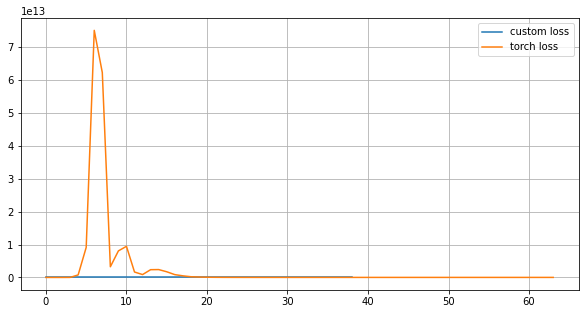

In [253]:
compare_sgd(input_2d, lambda model: torch.optim.SGD(model.parameters(), lr=DEFAULT_LR, momentum=0.7), sgd_with_momentum, DEFAULT_LR, param_1=0.7)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.SGD(model.parameters(), lr=DEFAULT_LR, momentum=0.8), sgd_with_momentum, DEFAULT_LR, param_1=0.8)

#### SGD with Nesterov momentum

custom sgd result:
coeffs: [-6.58460779  0.29297148]
epoches: 46
loss: 0.47336380288904956


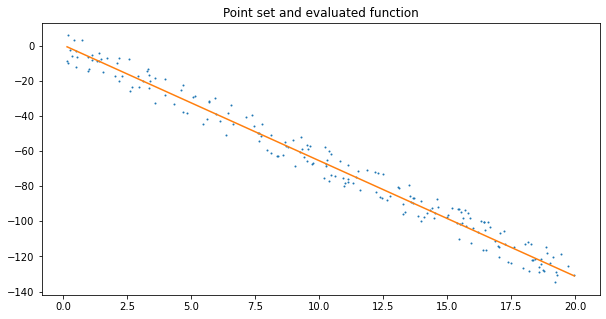



torch sgd result:
coeffs: [-6.1228695  0.3041304]
epoches: 44
loss: 0.2960994338989258


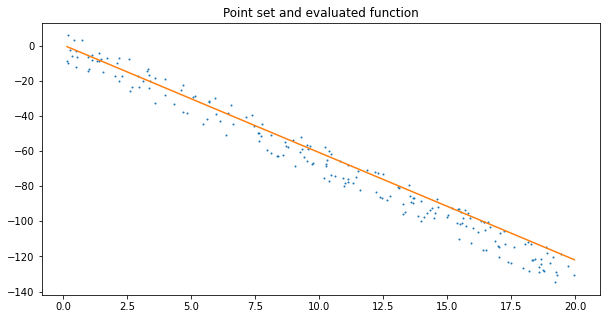

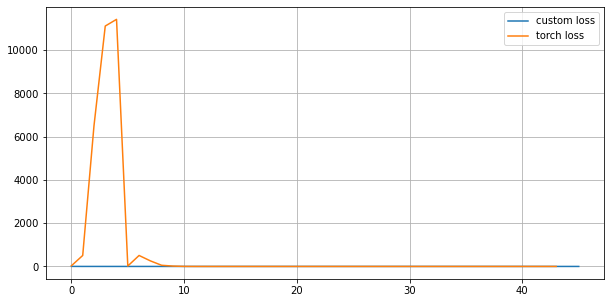

===large input===

custom sgd result:
coeffs: [ -1.97055262  -7.11164157  -5.10898001   2.35210166  -8.25786203
 -10.11429773  -8.29624191  -8.29308032  -7.49042489  -0.24483888]
epoches: 141
loss: 41.119850493107236


torch sgd result:
coeffs: [-4.2971     -6.7805924  -6.0238957  -1.7918375  -7.286638   -7.8720937
 -6.985147   -6.133853   -5.812812   -0.27675617]
epoches: 46
loss: 1.2491510009765625




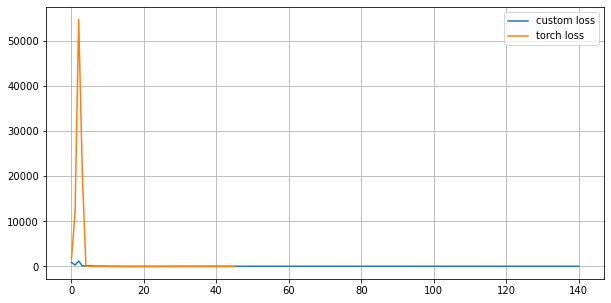

In [254]:
compare_sgd(input_2d, lambda model: torch.optim.SGD(model.parameters(), lr=DEFAULT_LR, momentum=0.7, nesterov=True), sgd_with_nesterov_momentum, DEFAULT_LR, param_1=0.7)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True), sgd_with_nesterov_momentum, 0.001, param_1=0.9)


#### Adagrad

custom sgd result:
coeffs: [-6.08402181 -5.31246536]
epoches: 32
loss: 0.13577283011666366


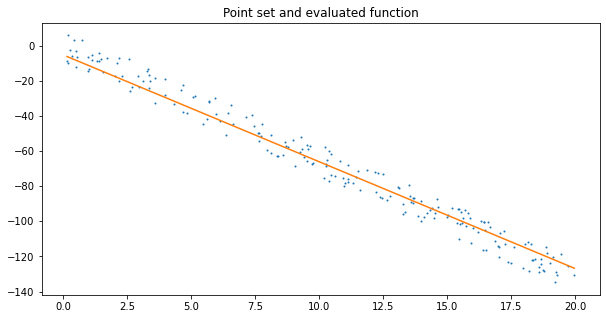



torch sgd result:
coeffs: [-4.15329   -3.6117747]
epoches: 38
loss: 3.4240985107421875


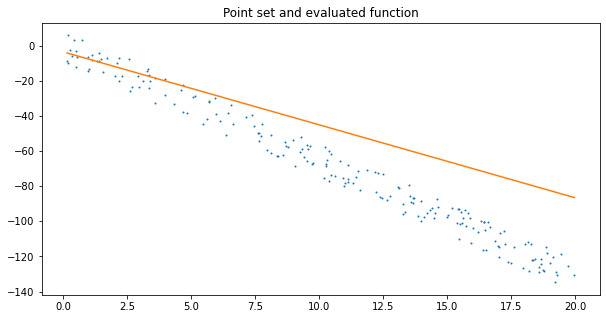

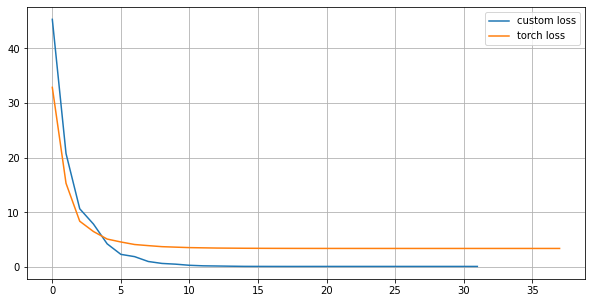

===large input===

custom sgd result:
coeffs: [-5.41812889 -5.60514091 -5.81904852 -5.17716359 -5.59382417 -5.66807694
 -5.92402857 -5.49333096 -5.83860925 -5.83974939]
epoches: 35
loss: 106.05657075277713


torch sgd result:
coeffs: [-3.2481804 -3.1175933 -3.4897053 -3.172657  -3.100801  -3.1338456
 -3.5510721 -3.1834745 -3.6342242 -3.5561597]
epoches: 40
loss: 305.023515625




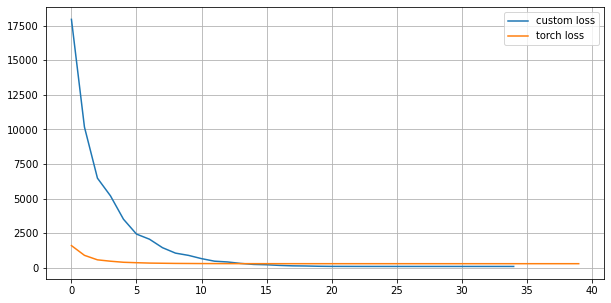

In [255]:
compare_sgd(input_2d, lambda model: torch.optim.Adagrad(model.parameters(), lr=2), adagrad, 2)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.Adagrad(model.parameters(), lr=1.5), adagrad, 1.5)

#### RMS Prop

custom sgd result:
coeffs: [-6.17283286 -4.86420785]
epoches: 35
loss: 0.16353232016714525


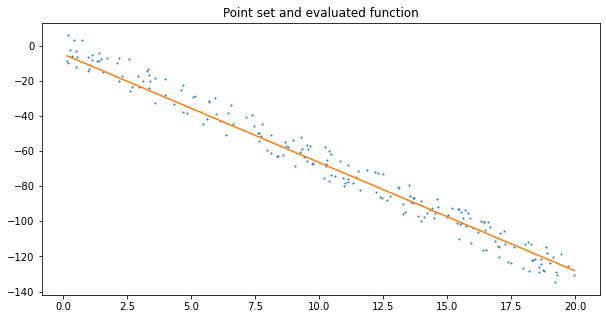



torch sgd result:
coeffs: [-6.019863  -6.6146874]
epoches: 36
loss: 0.20578886032104493


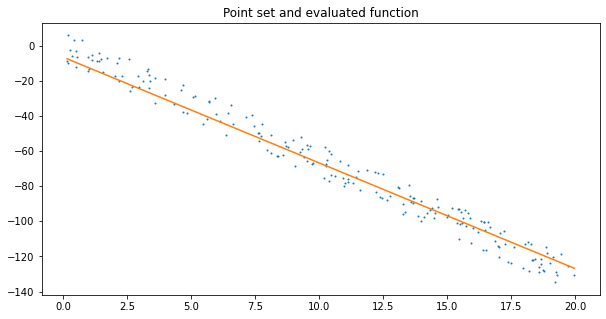

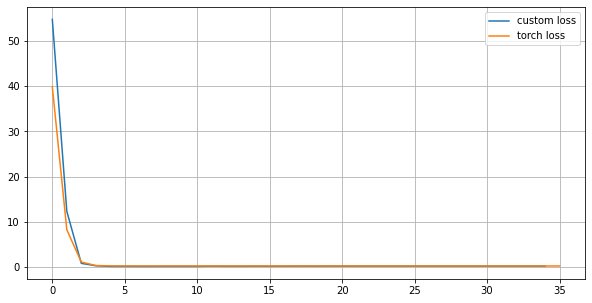

===large input===

custom sgd result:
coeffs: [-4.49494016 -6.51652854 -5.96338437 -2.46842224 -7.19702903 -7.60924478
 -6.74393715 -5.98465942 -5.53538116 -5.57558394]
epoches: 39
loss: 13.465475803870387


torch sgd result:
coeffs: [-4.493547  -4.848958  -4.947331  -3.8708415 -5.1123266 -5.504295
 -4.8663287 -4.892934  -4.4895983 -4.581543 ]
epoches: 50
loss: 60.002080078125




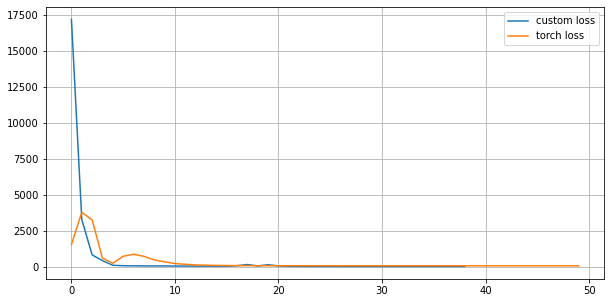

In [256]:
compare_sgd(input_2d, lambda model: torch.optim.RMSprop(model.parameters(), lr=1), rms_prop, 1, param_1=0.99)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.RMSprop(model.parameters(), lr=1.5, momentum=0.8), rms_prop, 1.5, param_1=0.8)

#### Adam

custom sgd result:
coeffs: [-6.51136319 -3.66040147]
epoches: 38
loss: 0.33178539769968013


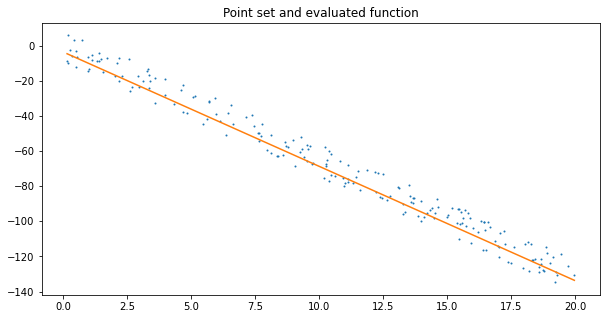



torch sgd result:
coeffs: [-3.1997325 -3.5790982]
epoches: 42
loss: 7.016476440429687


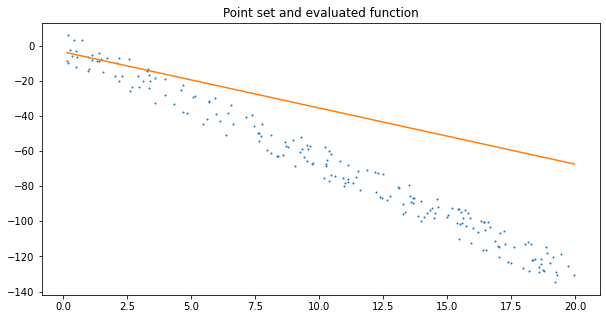

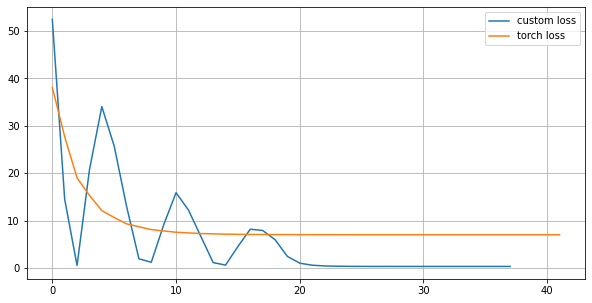

===large input===

custom sgd result:
coeffs: [-4.82029588 -5.32056834 -5.66656046 -4.25086446 -5.64020704 -5.72913217
 -5.65110192 -5.44295001 -5.53357266 -5.47575682]
epoches: 39
loss: 213.63269579191547


torch sgd result:
coeffs: [-3.8816829 -3.660298  -4.2496424 -3.7948818 -3.8526957 -3.79307
 -4.014886  -3.9921782 -4.0818653 -4.1261644]
epoches: 44
loss: 177.6785546875




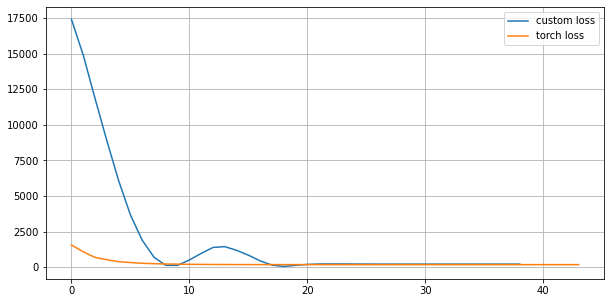

In [257]:
compare_sgd(input_2d, lambda model: torch.optim.Adam(model.parameters(), lr=1), adam, 1, param_1=0.9, param_2=0.999)
print("===large input===\n")
compare_sgd(input_large, lambda model: torch.optim.Adam(model.parameters(), lr=1, betas=(0.8, 0.8)), adam, 1, param_1=0.8, param_2=0.8)